In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

Data comes from Kaggle: https://www.kaggle.com/irfanazeem/used-cars-sale-price

In [2]:
sales = pd.read_csv('car_train.csv')
sales_select = sales.loc[:, ['price', 'economy', 'odometer', 'year', 'model', 'colour']]
sales_select_nona = sales_select.dropna()

## Clean the data

The dataset is very large (38k rows). Dropping NAs could bias the data (perhaps older or more unreliable cars are more likely to have missing data?) and potentially this should be investigated in more detail. However, for the purposes of this exercise feature selection is more important. 

In [3]:
# Clean colour
normal_colours = ['White', 'Silver', 'Grey', 'Blue', 'Black', 'Red']
sales_select_nona.loc[~sales_select_nona.colour.isin(normal_colours), 'colour' ] = 'Other'
sales_select_nona.colour.value_counts()

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


White     8845
Silver    7140
Grey      5379
Blue      3990
Black     3509
Red       2053
Other     1891
Name: colour, dtype: int64

In [4]:
## Check models are clean

sales_select_nona.model.value_counts()

Forester    12163
RAV4        10403
Impreza     10241
Name: model, dtype: int64

In [5]:
sales_select_num = sales_select_nona.loc[:, ['price', 'economy', 'odometer', 'year']]

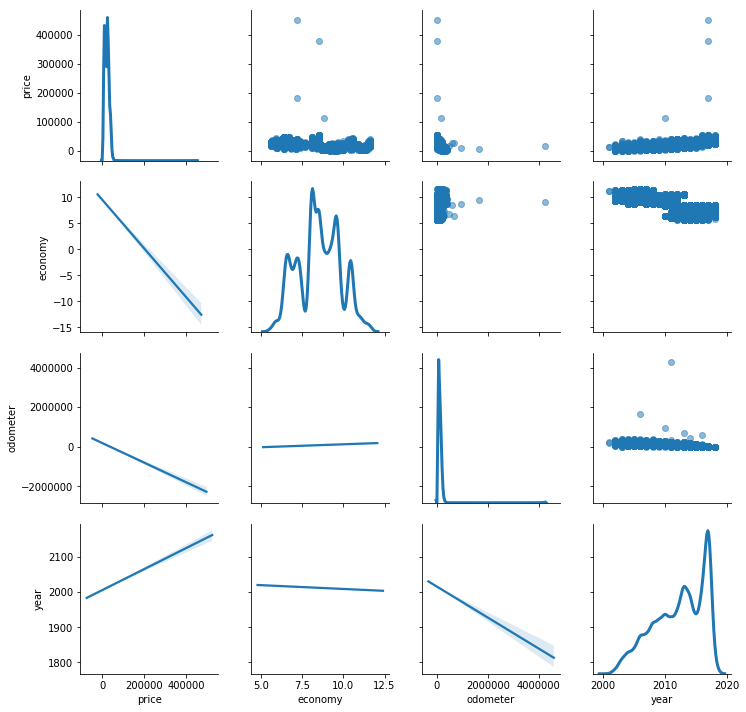

In [6]:
## Look for numeric outliers

sales_select_num = sales_select_nona.loc[:, ['price', 'economy', 'odometer', 'year']]
g= sns.PairGrid(sales_select_num, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [7]:
## Price - outliers above $80,000

sales_select_nona.loc[sales_select_nona.price > 80000,]

,price,economy,odometer,year,model,colour
25145,182501.0,7.2,148.0,2017,Impreza,Blue
25153,450610.0,7.2,545.0,2017,Impreza,Silver
28243,380043.0,8.5,12652.0,2017,RAV4,Black
29189,112984.0,8.8,148292.0,2010,Impreza,Grey


In [8]:
## Four cars are over $80,000 and all are over $110,000.
## Brand new Imprezas cost under $20k, and RAV4s cost $25k.
## Potentially decimal point issue but unclear so will remove.

sales_select_nona = sales_select_nona.loc[sales_select_nona.price < 100000,]

In [9]:
## Odometer - outliers over 400,000 miles.

sales_select_nona.loc[sales_select_nona.odometer > 400000,]

,price,economy,odometer,year,model,colour
1308,2017.0,8.8,403009.0,2004,Forester,Other
1965,17999.0,6.8,460557.0,2014,Impreza,Silver
6109,8517.0,9.4,1644778.0,2006,Impreza,Silver
12813,17018.0,9.1,4265814.0,2011,RAV4,Red
23915,9556.0,8.8,935468.0,2010,Impreza,Blue
24447,26535.0,8.5,600576.0,2016,RAV4,White
30269,29068.0,6.5,676183.0,2013,RAV4,Grey


In [10]:
## Removing the two with over 1 million miles.

sales_select_nona = sales_select_nona.loc[sales_select_nona.odometer < 1000000,]

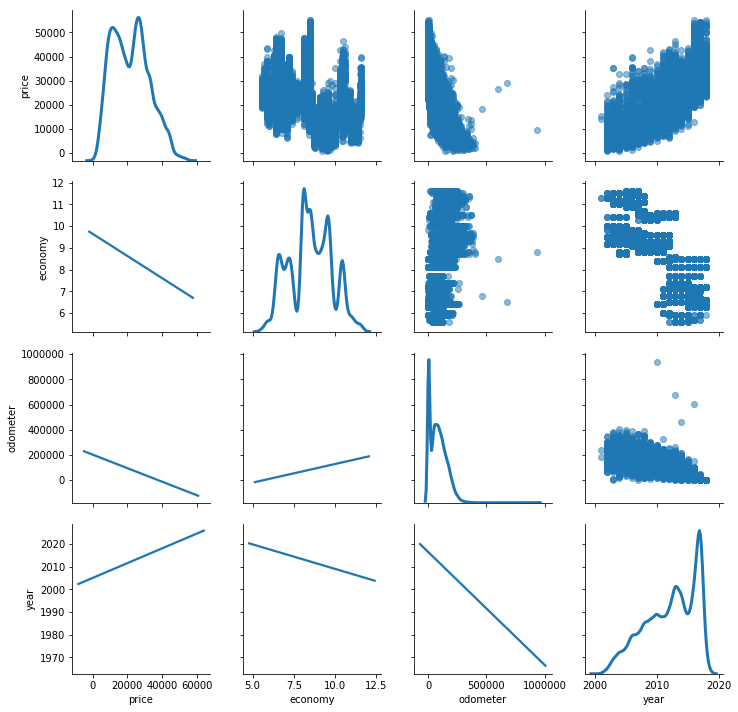

In [11]:
## Replot pairplots

sales_select_num = sales_select_nona.loc[:, ['price', 'economy', 'odometer', 'year']]
g= sns.PairGrid(sales_select_num, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [12]:
## Change df name to shorter one

ssn = sales_select_nona

## Univariate explorations

In [13]:
## Continuous variables

ssn.describe()

,price,economy,odometer,year
count,32801.000000,32801.000000,32801.000000,32801.000000
mean,22099.846682,8.523798,83631.584586,2012.187098
std,10555.538168,1.270496,69081.610607,4.064363
min,828.000000,5.600000,0.000000,2001.000000
25%,13042.000000,7.400000,20635.000000,2009.000000
50%,22004.000000,8.500000,75666.000000,2013.000000
75%,29503.000000,9.600000,129590.000000,2016.000000
max,55077.000000,11.600000,935468.000000,2018.000000


In [14]:
## Categorical variables

ssn.describe(include='object')

,model,colour
count,32801,32801
unique,3,7
top,Forester,White
freq,12163,8845


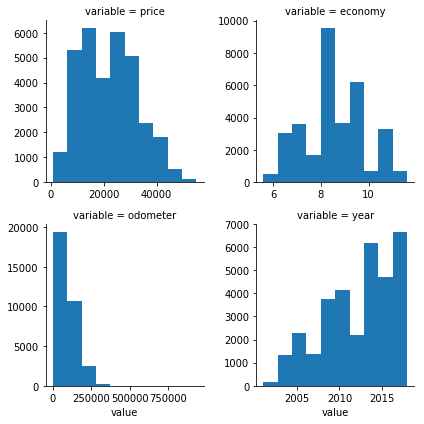

In [15]:
## Plot continuous variable histograms

ssn_num = ssn.loc[:, ['price', 'economy', 'odometer', 'year']]
ssn_num_long = pd.melt(ssn_num)
ssn_num_long.head()

g = sns.FacetGrid(ssn_num_long, col='variable', col_wrap=2,
                 sharex=False,
                 sharey=False)
g.map(plt.hist, 'value')
plt.show()

In [16]:
ssn_cat = ssn.loc[:, ['model', 'colour']]
ssn_model_counts = ssn_cat.model.value_counts().to_frame().reset_index()
ssn_model_counts.head()

,index,model
0,Forester,12163
1,RAV4,10401
2,Impreza,10237


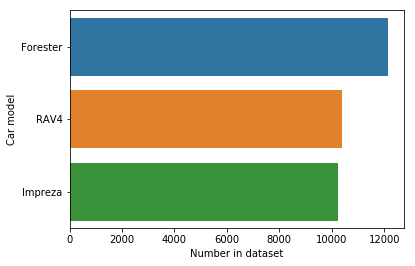

In [17]:
## Plot model barplot

g = sns.barplot(x='model', y='index', data=ssn_model_counts)
g.set_xlabel('Number in dataset')
g.set_ylabel('Car model')
plt.show()

In [18]:
## Arrange car colours for plot

ssn_colour_counts = ssn_cat.colour.value_counts().to_frame().reset_index()
car_colours = ssn_colour_counts['index'].tolist()
car_colours_lower = list(map(lambda x: x.lower(), car_colours))

## Adjust for visibility

adjust_colours = {
    'white': 'whitesmoke',
    'other': 'hotpink'
}

car_colours_palette = [adjust_colours.get(item, item) for item in car_colours_lower]

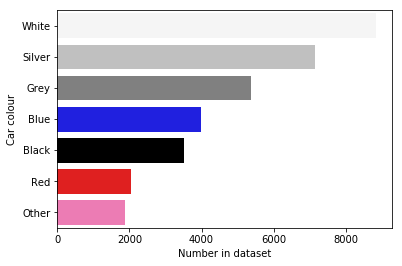

In [19]:
## Car colours plot

g = sns.barplot(x='colour', y='index', data=ssn_colour_counts,
               palette=car_colours_palette)
g.set_xlabel('Number in dataset')
g.set_ylabel('Car colour')
plt.show()

## Bivariate explorations

The pairplot was already considered when cleaning the data but is replotted here for completeness.

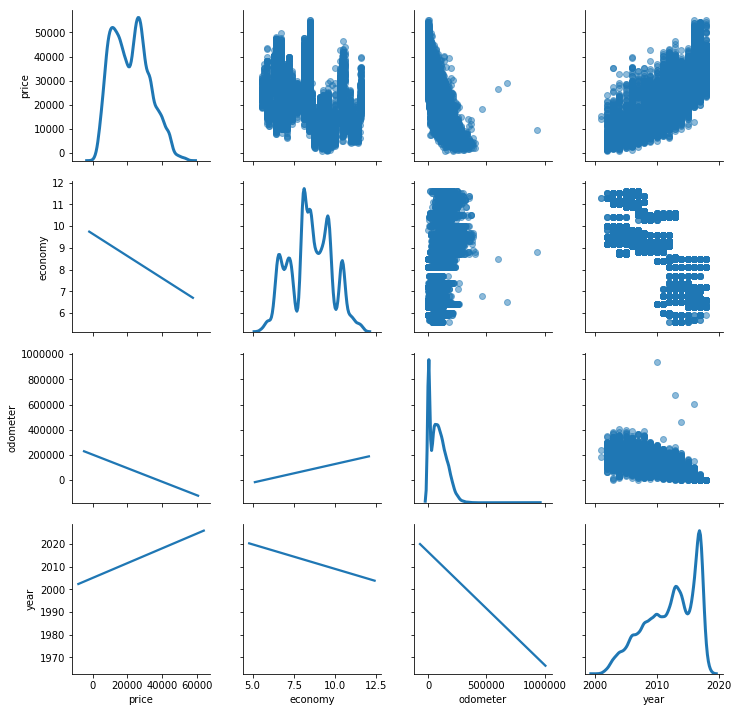

In [20]:
g= sns.PairGrid(ssn_num, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

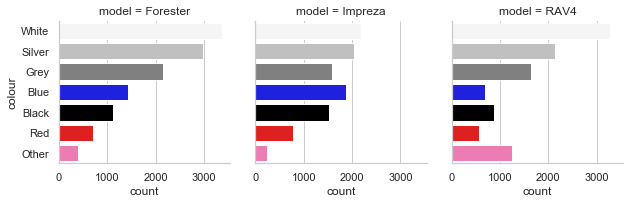

In [21]:
## Model versus colour

ssn_model_colour = ssn.groupby(['model', 'colour']).count().reset_index()
ssn_model_colour = ssn_model_colour.loc[:, ['model', 'colour', 'price']]
ssn_model_colour.columns = ['model', 'colour', 'count']

sns.set(style='whitegrid')

g = sns.FacetGrid(ssn_model_colour, col='model')
g.map(sns.barplot,'count', 'colour', order=car_colours,
     palette=car_colours_palette)
plt.show()

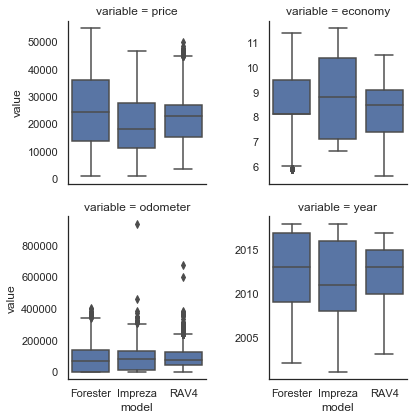

In [22]:
## Model versus continuous variables

ssn_model_long = pd.melt(ssn.loc[:, ['model', 'price', 'economy', 'odometer', 'year']], id_vars='model')

sns.set(style='white')
g = sns.FacetGrid(ssn_model_long, col='variable', col_wrap=2,
                 sharey=False)
g.map(sns.boxplot, 'model', 'value', order=['Forester', 'Impreza', 'RAV4'])
plt.show()

In [23]:
ssn.groupby('model').describe().T

model                Forester        Impreza           RAV4
price    count   12163.000000   10237.000000   10401.000000
         mean    24835.384034   19100.461854   21852.982117
         std     12704.876478    8999.456743    8078.208210
         min       864.000000     828.000000    3346.000000
         25%     13800.500000   11038.000000   15082.000000
         50%     24468.000000   17934.000000   22902.000000
         75%     36007.500000   27563.000000   27039.000000
         max     55077.000000   46586.000000   49932.000000
economy  count   12163.000000   10237.000000   10401.000000
         mean        8.616032       8.624783       8.316546
         std         1.129503       1.551444       1.080244
         min         5.900000       6.600000       5.600000
         25%         8.100000       7.100000       7.400000
         50%         8.100000       8.800000       8.500000
         75%         9.500000      10.400000       9.100000
         max        11.400000      11.600000      10.500000
odometer count   12163.000000   10237.000000   10401.000000
         mean    80824.784593   82704.696591   87826.148640
         std     78424.829245   68069.990998   57187.476154
         min         0.000000       0.000000      61.000000
         25%      1345.000000   10112.000000   45393.000000
         50%     71399.000000   81563.000000   74642.000000
         75%    137322.000000  129400.000000  122670.000000
         max    403009.000000  935468.000000  676183.000000
year     count   12163.000000   10237.000000   10401.000000
         mean     2012.624024    2011.348149    2012.501875
         std         4.291964       4.301222       3.366409
         min      2002.000000    2001.000000    2003.000000
         25%      2009.000000    2008.000000    2010.000000
         50%      2013.000000    2011.000000    2013.000000
         75%      2017.000000    2016.000000    2015.000000
         max      2018.000000    2018.000000    2017.000000

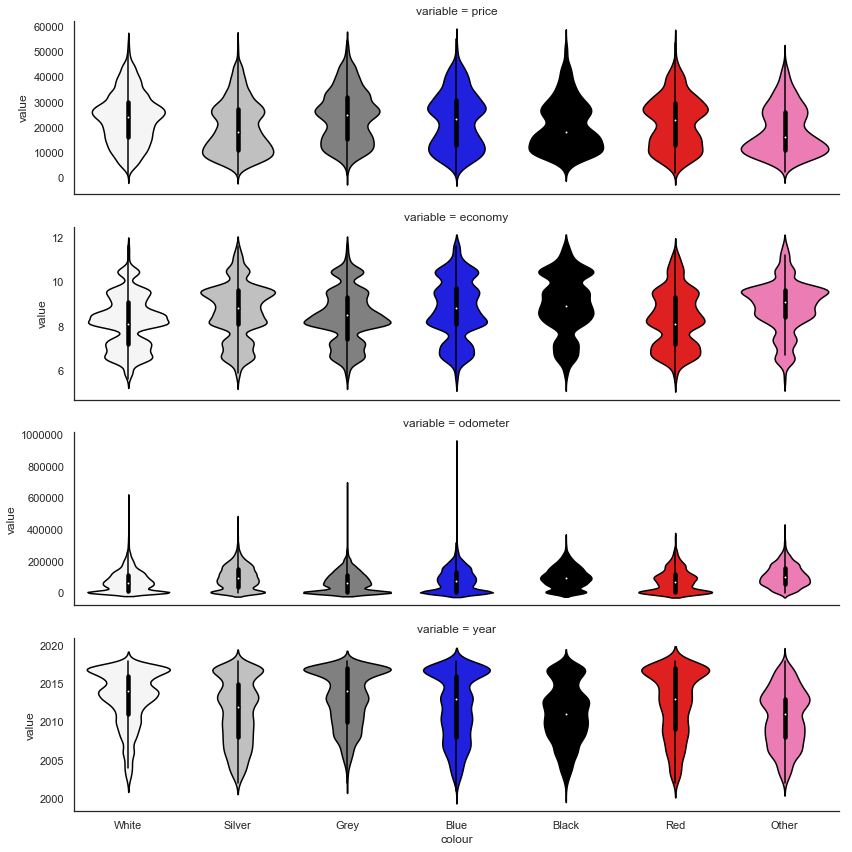

In [24]:
## Colour versus continous variables
## Could remove highest odometer values so charts not squashed?

ssn_colour_long = pd.melt(ssn.loc[:, ['colour', 'price', 'economy', 'odometer', 'year']], id_vars='colour')

g = sns.FacetGrid(ssn_colour_long, row='variable', aspect=4, sharey=False)
g.map(sns.violinplot, 'colour', 'value', order=car_colours,
     palette=car_colours_palette)
plt.show()

## Feature selection

In [25]:
features = pd.concat([pd.get_dummies(ssn['model']), pd.get_dummies(ssn['colour'])], axis=1)
features.head()

,Forester,Impreza,RAV4,Black,Blue,Grey,Other,Red,Silver,White
0,0,1,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0


In [26]:
## Above average mileage
## Average mileage is around 15,000 per year

ssn_mileage = ssn.copy()
ssn_mileage['age'] = 2019 - ssn_mileage['year']
ssn_mileage['exp_mileage'] = ssn_mileage['age'] * 15000
ssn_mileage['mileage_status'] = np.where(ssn_mileage['exp_mileage'] > ssn_mileage['odometer'], 'below average', 'above average')
features['above_av_mileage'] = np.where(ssn_mileage.mileage_status == 'above average', 1, 0)
features.head()

,Forester,Impreza,RAV4,Black,Blue,Grey,Other,Red,Silver,White,above_av_mileage
0,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0


In [27]:
## Year, economy and odometer are a bit correlated - use PCA

ssn_yeo = ssn.loc[:, ['year', 'economy', 'odometer']]

ssn_yeo_X = StandardScaler().fit_transform(ssn_yeo)

sklearn_pca = PCA(n_components=3) # Specify number of components you want out.
Y_sklearn = sklearn_pca.fit_transform(ssn_yeo_X)

sklearn_pca.explained_variance_ratio_

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([0.7943119 , 0.16007666, 0.04561144])

In [28]:
## Use first component only

features['pca_yeo'] = Y_sklearn[:, 0]
features.head()

,Forester,Impreza,RAV4,Black,Blue,Grey,Other,Red,Silver,White,above_av_mileage,pca_yeo
0,0,1,0,0,0,0,0,0,1,0,0,1.072784
1,0,1,0,0,0,0,0,0,1,0,0,-1.418996
2,0,1,0,0,1,0,0,0,0,0,0,0.925164
3,0,1,0,1,0,0,0,0,0,0,0,0.296780
4,0,1,0,0,0,1,0,0,0,0,0,0.732997


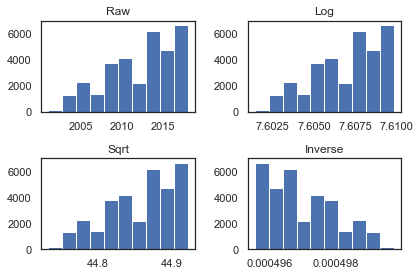

In [29]:
## Year is not a particularly normal looking variable - try transform

fig = plt.figure()

fig.add_subplot(221)
plt.hist(ssn['year'])
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(ssn['year']))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(ssn['year']))
plt.title('Sqrt')

fig.add_subplot(224)
plt.hist(1/(ssn['year']))
plt.title('Inverse')

plt.tight_layout()
plt.show()

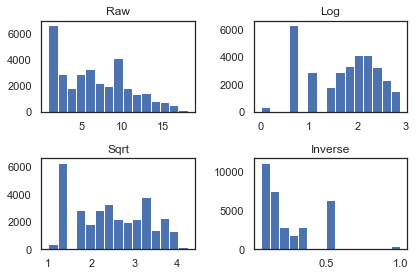

In [30]:
## None were good. Try age of car instead of year

fig = plt.figure()

fig.add_subplot(221)
plt.hist(ssn_mileage['age'], bins=15)
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(ssn_mileage['age']), bins=15)
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(ssn_mileage['age']), bins=15)
plt.title('Sqrt')

fig.add_subplot(224)
plt.hist(1/(ssn_mileage['age']), bins=15)
plt.title('Inverse')

plt.tight_layout()
plt.show()

In [31]:
## Not much better but perhaps square root looks most normal?

features['sqrt_age'] = np.sqrt(ssn_mileage['age'])
features.head()

,Forester,Impreza,RAV4,Black,Blue,Grey,Other,Red,Silver,White,above_av_mileage,pca_yeo,sqrt_age
0,0,1,0,0,0,0,0,0,1,0,0,1.072784,3.162278
1,0,1,0,0,0,0,0,0,1,0,0,-1.418996,2.236068
2,0,1,0,0,1,0,0,0,0,0,0,0.925164,3.464102
3,0,1,0,1,0,0,0,0,0,0,0,0.296780,3.162278
4,0,1,0,0,0,1,0,0,0,0,0,0.732997,2.828427


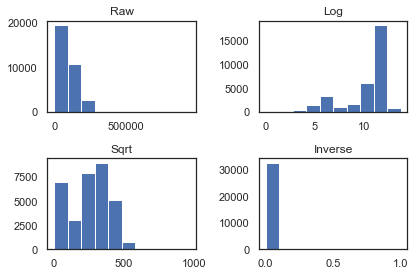

In [32]:
## Odometer is non normal
## Add 1 to remove zero problems

fig = plt.figure()

fig.add_subplot(221)
plt.hist(ssn['odometer']+1)
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(ssn['odometer']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(ssn['odometer']+1))
plt.title('Sqrt')

fig.add_subplot(224)
plt.hist(1/(ssn['odometer']+1))
plt.title('Inverse')

plt.tight_layout()
plt.show()

In [33]:
features['sqrt_odometer'] = np.sqrt(ssn['odometer'] +1)

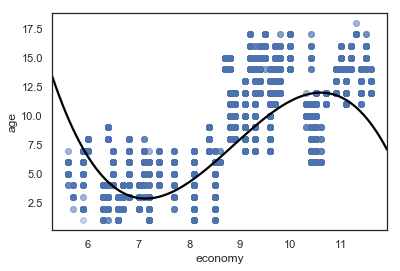

In [34]:
## Higher order relationships

sns.regplot(
    ssn_mileage['economy'],
    ssn_mileage['age'],
    order=3,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.show()

In [35]:
features['economy_cubed'] = ssn['economy']**3
features.head()

,Forester,Impreza,RAV4,Black,Blue,Grey,Other,Red,Silver,White,above_av_mileage,pca_yeo,sqrt_age,sqrt_odometer,economy_cubed
0,0,1,0,0,0,0,0,0,1,0,0,1.072784,3.162278,367.348608,704.969
1,0,1,0,0,0,0,0,0,1,0,0,-1.418996,2.236068,182.496575,314.432
2,0,1,0,0,1,0,0,0,0,0,0,0.925164,3.464102,285.777886,704.969
3,0,1,0,1,0,0,0,0,0,0,0,0.296780,3.162278,219.207664,681.472
4,0,1,0,0,0,1,0,0,0,0,0,0.732997,2.828427,226.973567,1157.625


## Filtering

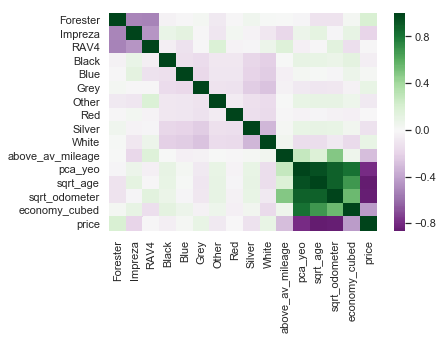

In [36]:
features['price'] = ssn['price']
features_corr = features.corr()
sns.heatmap(features_corr, cmap='PRGn', center=0)
plt.show()

In [37]:
features_corr.price

Forester            0.198955
Impreza            -0.191398
RAV4               -0.015937
Black              -0.050884
Blue                0.018868
Grey                0.097040
Other              -0.079742
Red                -0.003112
Silver             -0.117522
White               0.093433
above_av_mileage   -0.291673
pca_yeo            -0.793133
sqrt_age           -0.862014
sqrt_odometer      -0.847982
economy_cubed      -0.425660
price               1.000000
Name: price, dtype: float64

In [38]:
## RAV4, Black, Blue, Grey, Other, Red and White all have 
## under abs(0.1) correlation with price so remove as pretty useless.

features_select = features.loc[:, ['Forester', 'Impreza', 'Silver', 'above_av_mileage', 'pca_yeo', 'sqrt_age', 'sqrt_odometer', 'economy_cubed']]
features_variance = features_select.apply(lambda x: np.var(x))
features_variance

Forester                0.233310
Impreza                 0.214691
Silver                  0.170259
above_av_mileage        0.186317
pca_yeo                 2.382936
sqrt_age                0.638301
sqrt_odometer       20594.556324
economy_cubed       81903.712331
dtype: float64

In [39]:
## sqrt_odometer and economy_cubed are much larger than the others
## simply as a result of the scales on which the variables are on.

In [41]:
## Standardize by using standard deviation and dividing by mean.
## Gives variation per unit of mean.

features_select = features.loc[:, ['Forester', 'Impreza', 'Silver', 'above_av_mileage', 'pca_yeo', 'sqrt_age', 'sqrt_odometer', 'economy_cubed']]
features_std = features_select.apply(lambda x: np.std(x))
features_std / features_select.apply(lambda x: np.mean(x))

Forester            1.302607e+00
Impreza             1.484642e+00
Silver              1.896118e+00
above_av_mileage    1.742997e+00
pca_yeo             3.454041e+16
sqrt_age            3.215203e-01
sqrt_odometer       5.715772e-01
economy_cubed       4.332270e-01
dtype: float64